# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

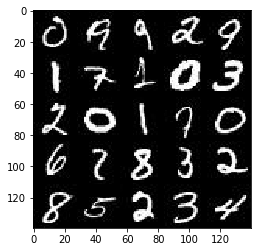

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

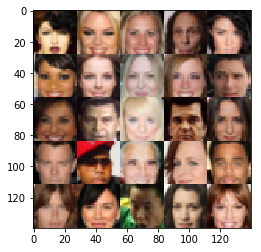

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32,shape=(None, image_width, image_height, image_channels), name='inputs_real') 
    inputs_z = tf.placeholder(tf.float32,shape=(None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32,shape=(None), name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
  
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(x1, 128, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d(x2, 256, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
            
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smoothing = 0.1
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real, reuse=False)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)

    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_logits_real, 
            labels=tf.ones_like(discriminator_model_real) * (1 - smoothing)))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_logits_fake, 
            labels=tf.zeros_like(discriminator_model_fake)))
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_logits_fake, 
            labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake

    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_training_operation = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        generator_training_operation = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    
    return discriminator_training_operation, generator_training_operation

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    discriminator_loss, generator_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    discriminator_training_operation, generator_training_operation = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    step = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                # double training images
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
                # Run optimizers
                _ = sess.run(discriminator_training_operation, feed_dict={inputs_real:batch_images, inputs_z:batch_z, lr:learning_rate})
                _ = sess.run(generator_training_operation, feed_dict={inputs_z:batch_z, inputs_real:batch_images, lr:learning_rate})

                
                if step % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = discriminator_loss.eval({inputs_z:batch_z, inputs_real:batch_images})
                    train_loss_g = generator_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)) 

                    
                if step % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
     
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4715... Generator Loss: 2.3560
Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 1.2944


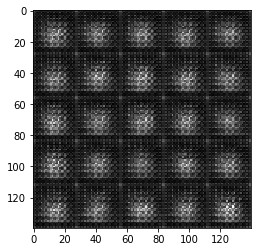

Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 1.8385
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.7643


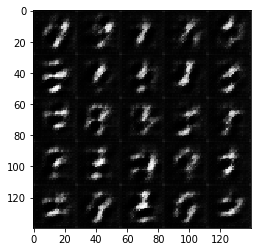

Epoch 1/2... Discriminator Loss: 0.9056... Generator Loss: 2.0754
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 1.3403


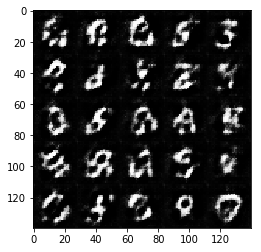

Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 1.7837
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 1.0619


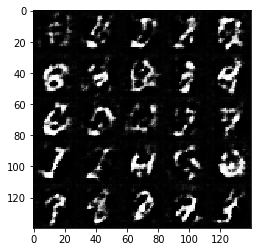

Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 0.9368
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.6680


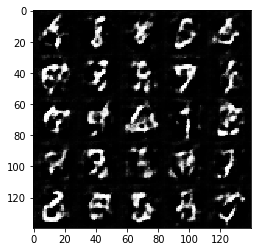

Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 2.7888
Epoch 1/2... Discriminator Loss: 0.8815... Generator Loss: 1.5216


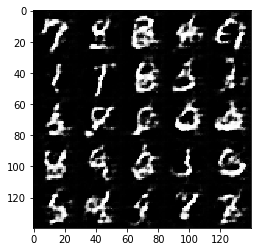

Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 1.5099
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 1.2929


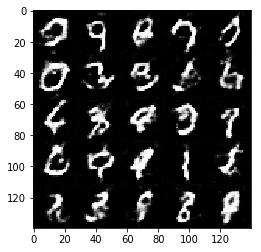

Epoch 1/2... Discriminator Loss: 1.0434... Generator Loss: 0.8200
Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 1.5444


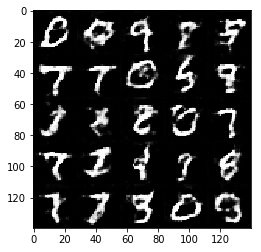

Epoch 1/2... Discriminator Loss: 1.0823... Generator Loss: 0.7292
Epoch 1/2... Discriminator Loss: 0.9096... Generator Loss: 1.1367


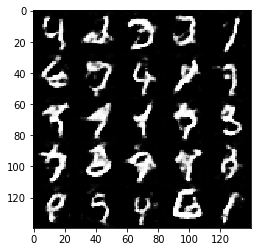

Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 2.1709
Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 1.1856


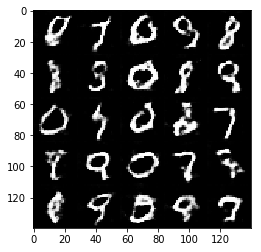

Epoch 2/2... Discriminator Loss: 0.7764... Generator Loss: 1.3200
Epoch 2/2... Discriminator Loss: 0.7366... Generator Loss: 1.6021


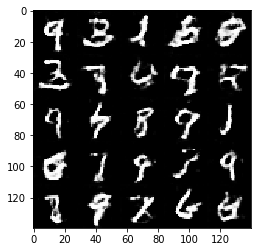

Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.2221
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.1087


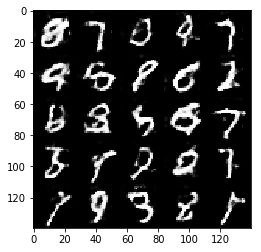

Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 1.0930


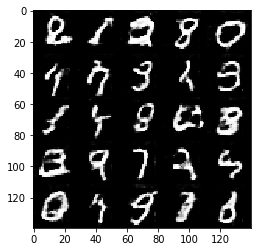

Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 1.9863
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 2.7191


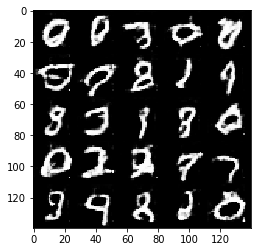

Epoch 2/2... Discriminator Loss: 1.0531... Generator Loss: 0.7893
Epoch 2/2... Discriminator Loss: 2.2193... Generator Loss: 0.3213


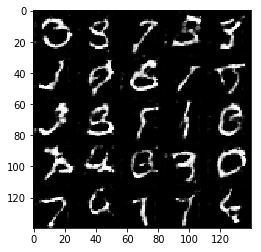

Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 1.6116
Epoch 2/2... Discriminator Loss: 0.7644... Generator Loss: 1.4339


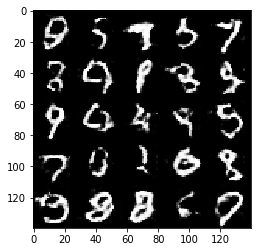

Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.3476


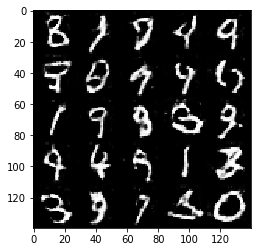

Epoch 2/2... Discriminator Loss: 0.7237... Generator Loss: 1.4496
Epoch 2/2... Discriminator Loss: 0.6647... Generator Loss: 1.5950


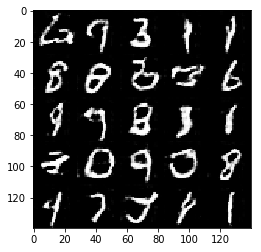

Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 1.0971


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.6581
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 3.5442


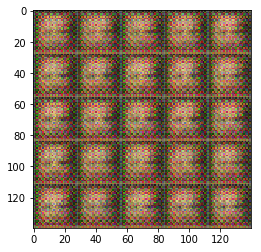

Epoch 1/1... Discriminator Loss: 1.8751... Generator Loss: 8.4876
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 3.0058


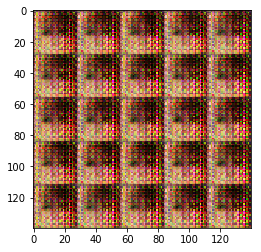

Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 3.3224
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.0081


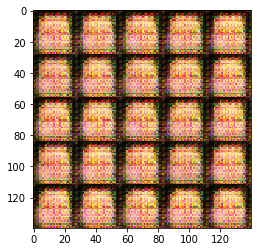

Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 3.2068
Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 2.2736


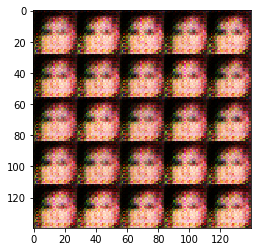

Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.5544
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.8565


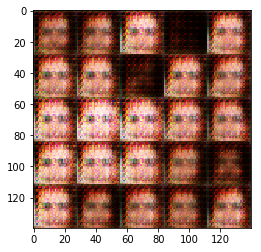

Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 2.3740
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.2417


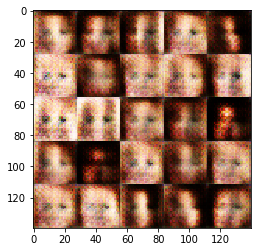

Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 2.2162
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 2.1433


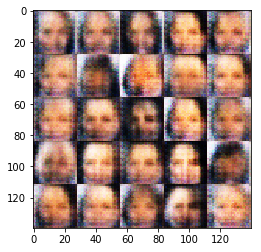

Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 3.7014


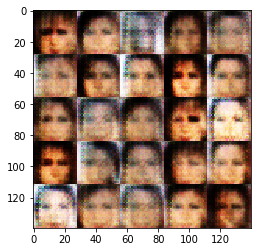

Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.4960
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8142


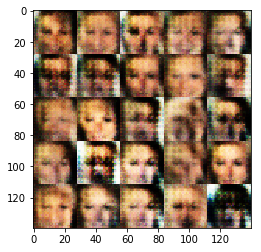

Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.7970


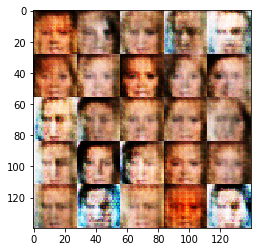

Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.5547


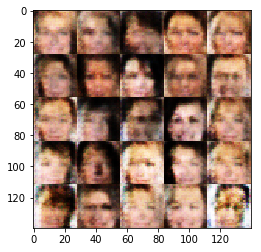

Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.2992
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.0740


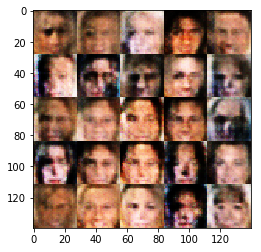

Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.8388


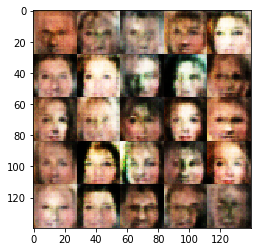

Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.4790


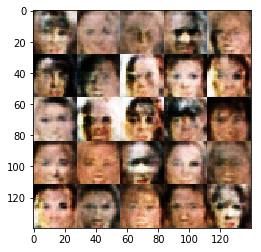

Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.6132
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.1086


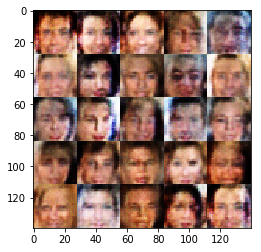

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.3219


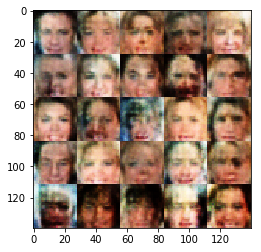

Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 2.0867
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.5356


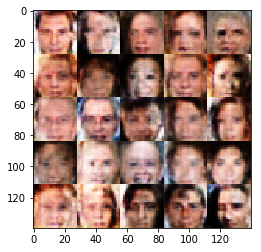

Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.1139


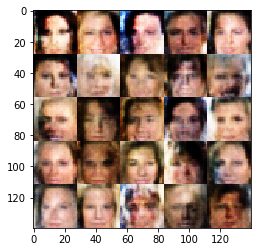

Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.9411


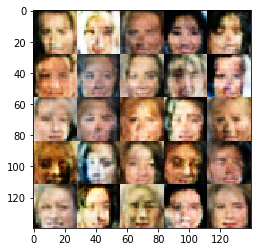

Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.8639


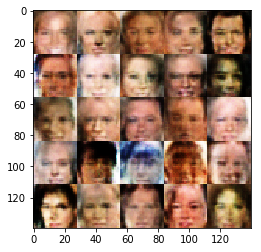

Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 2.5930


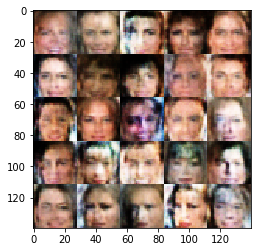

Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 0.7501... Generator Loss: 1.2841


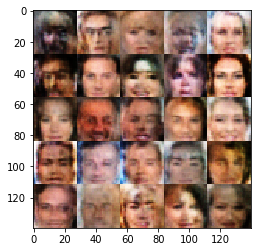

Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 3.3048


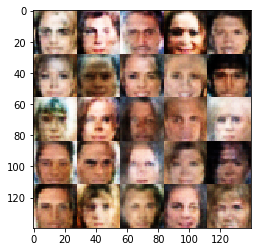

Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.9598


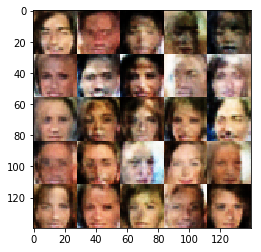

Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.3933


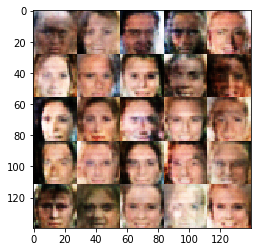

Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 2.5144


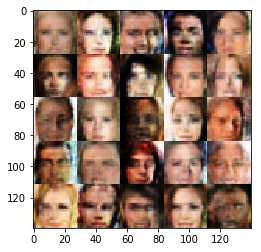

Epoch 1/1... Discriminator Loss: 1.6935... Generator Loss: 0.3364
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.8672


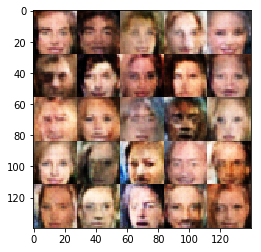

Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.8700


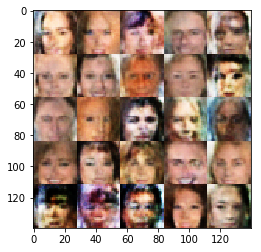

Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 1.3034


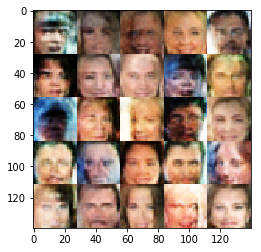

Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 2.0209


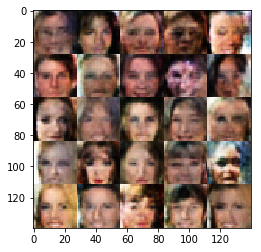

Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.4377
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.6897


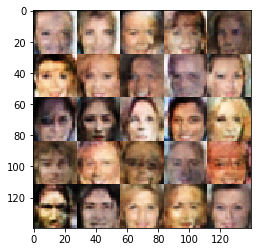

Epoch 1/1... Discriminator Loss: 0.6419... Generator Loss: 1.6038
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 2.4756


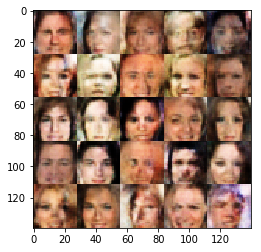

Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.2672


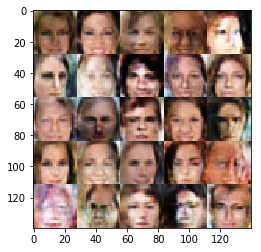

Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.5053


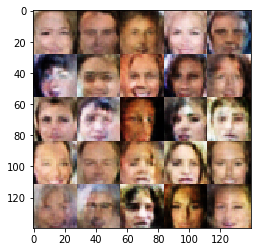

Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 1.6918
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.9070


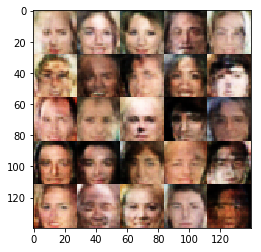

Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.2899


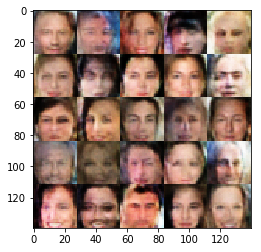

Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.4935


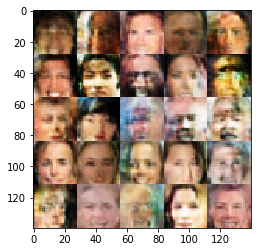

Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 3.1096
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6300


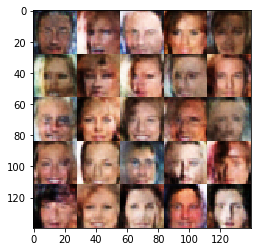

Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.2502
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.9394


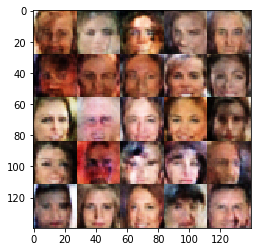

Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 3.8526


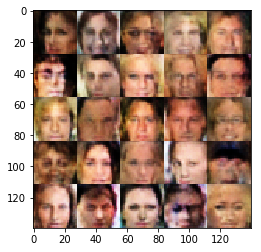

Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.5033


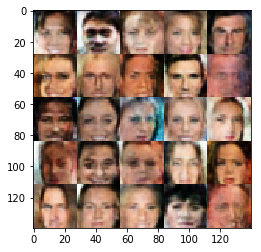

Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 1.5546


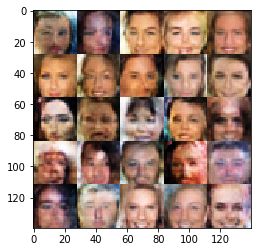

Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.9182
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.5733


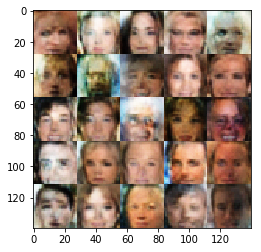

Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 1.8632


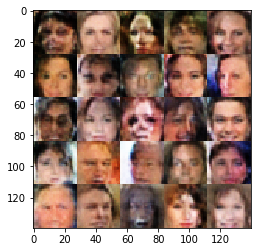

Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 2.0273


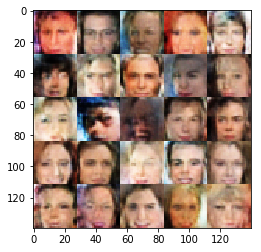

Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 2.1388
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.8215


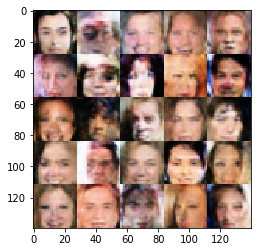

Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 0.8981


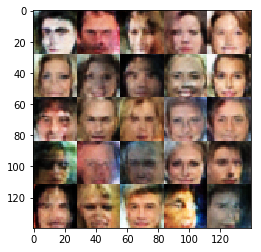

Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 2.2231
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 2.1086


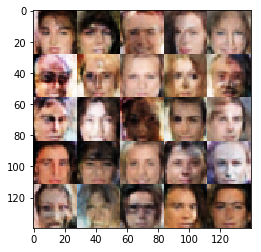

Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.6252


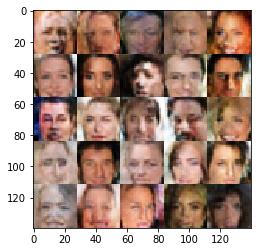

Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.1303


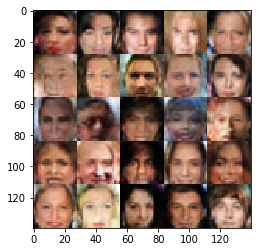

Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.9791
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 1.1349


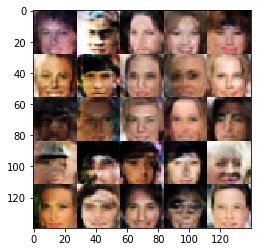

Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 2.8556
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 0.9898


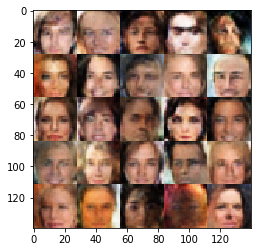

Epoch 1/1... Discriminator Loss: 1.7488... Generator Loss: 0.3233
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.4923


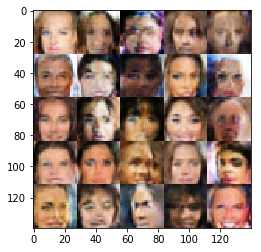

Epoch 1/1... Discriminator Loss: 2.2906... Generator Loss: 0.2040
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.5134


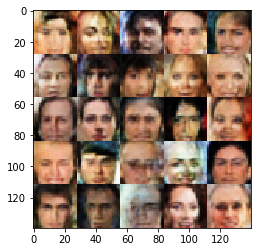

Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 2.4869
Epoch 1/1... Discriminator Loss: 1.6665... Generator Loss: 3.9255


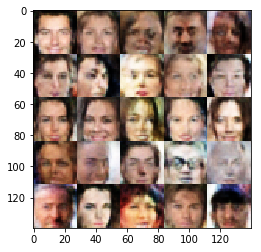

Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.0794


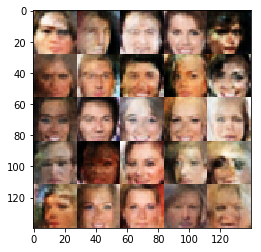

Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.7639


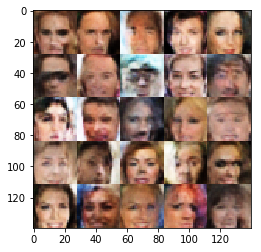

Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 2.0816
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 1.9093


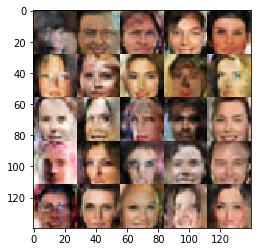

Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.6559


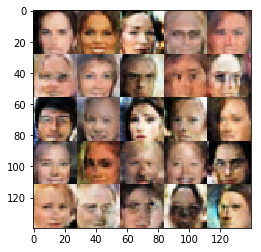

Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 2.1781
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 1.7497


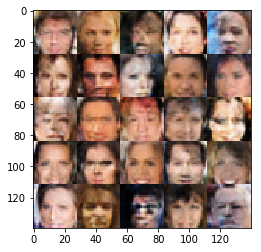

Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 2.9780
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.8039


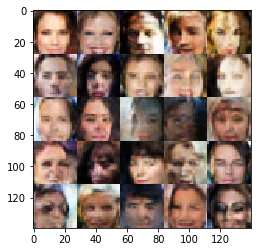

Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 2.3303
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.9806


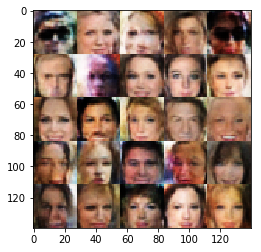

Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.8037
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.3863


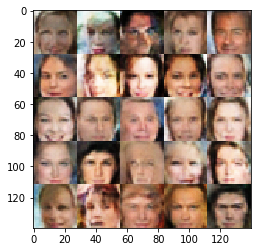

In [25]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.